# Previsão de sobrevivência no Titanic 🚢

### Objetivo 📌

Analisar o dataset da competição Titanic do Kaggle para prever a sobrevivência dos passageiros, utilizando técnicas de pré-processamento avançado, feature engineering detalhado e modelagem de Machine Learning. 

O foco é identificar os principais fatores que influenciam a sobrevivência, como classe, sexo e idade, e construir uma solução robusta que combine exploração de dados com otimização de modelos, visando alcançar um desempenho competitivo na submissão final.

## Configuração inicial e Carregamento de dados 🔋

In [113]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Set seaborn style for visualizations
sns.set()

In [114]:
# Load train and test datasets
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

## Exploração de dados 🧐

In [115]:
# Display first few rows of train data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [116]:
# Check for missing values in train data
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [117]:
# Check for duplicates in train data
train_data.duplicated().sum()

0

In [118]:
# Display train data information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Após uma análise inicial dos dataset `train`, identifiquei características críticas que orientam os próximos passos de preparação. A coluna `Cabin` apresentou uma quantidade significativa de valores ausentes (aproximadamente 77% no conjunto de treino), comprometendo sua utilidade preditiva, o que justifica sua remoção completa. Em contrapartida, a coluna `Age`, apesar de conter cerca de 20% de valores nulos, é um fator potencialmente relevante para a sobrevivência, indicando a necessidade de feature engineering para preenchê-los de forma contextualizada, em vez de descartá-los.

A verificação de duplicados revelou que o dataset está livre de registros redundantes, eliminando a necessidade de deduplicação. Para as variáveis categóricas (`Sex`, `Embarked`, e outras derivadas), optei pelo Label Encoding, transformando-as em valores numéricos de forma eficiente e compatível com os modelos de Machine Learning. A coluna `Embarked` apresentou apenas 2 valores ausentes no conjunto de treino, um percentual insignificante que permite sua remoção sem perda relevante de dados. Por fim, a coluna `Ticket` foi analisada e considerada irrelevante devido à sua alta variabilidade e falta de padrões claros associados à sobrevivência, levando à decisão de excluí-la.

Essas observações fundamentam as etapas seguintes: remover `Cabin`, `Ticket` e os 2 registros com `Embarked` nulo, aplicar feature engineering para tratar os valores ausentes em `Age`, e converter as variáveis categóricas em formato numérico com Label Encoding, preparando um dataset otimizado para modelagem.

## Limpeza e Tratamento de dados 🧼 

In [119]:
# Define function to preprocess data
def preprocess_data(dataframe):
    # Define nested function to fill missing Age values
    def fill_missing_age(row):
        if pd.isnull(row['Age']):
            return age_by_title_sex.loc[row['Title'], row['Sex']]
        return row['Age']
    
    # Extract titles from Name column
    dataframe['Title'] = dataframe['Name'].str.extract(r', ([A-Za-z]+)\.', expand=False)
    
    # Define title mapping for simplification
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss', 'Lady': 'Rare',
        'Sir': 'Rare', 'Capt': 'Rare', 'Countess': 'Rare', 'Jonkheer': 'Rare', 'Don': 'Rare'
    }
    
    # Apply title mapping and fill unmapped titles with 'Rare'
    dataframe['Title'] = dataframe['Title'].map(title_mapping).fillna('Rare')
    
    # Calculate mean age by title and sex for filling missing values
    global age_by_title_sex  # Declare as global to avoid UnboundLocalError
    age_by_title_sex = dataframe.groupby(['Title', 'Sex'])['Age'].mean().round(0)
    
    # Fill missing Age values using the defined function
    dataframe['Age'] = dataframe.apply(fill_missing_age, axis=1)
    
    # Drop unnecessary columns
    dataframe = dataframe.drop(columns=['Cabin', 'Ticket', 'Name'])
    
    # Remove rows with missing Embarked values
    dataframe = dataframe[~dataframe['Embarked'].isna()]
    
    # Define categorical columns for encoding
    categorical_cols = ['Sex', 'Embarked', 'Title']
    
    # Apply Label Encoding to categorical columns
    for col in categorical_cols:
        le = LabelEncoder()
        dataframe[col] = le.fit_transform(dataframe[col])
    
    return dataframe

In [120]:
# Preprocess train and test data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [121]:
# Display first few rows of preprocessed train data
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,1,22.0,1,0,7.2500,2,2
1,2,1,1,0,38.0,1,0,71.2833,0,3
2,3,1,3,0,26.0,0,0,7.9250,2,1
3,4,1,1,0,35.0,1,0,53.1000,2,3
4,5,0,3,1,35.0,0,0,8.0500,2,2


### Correlação

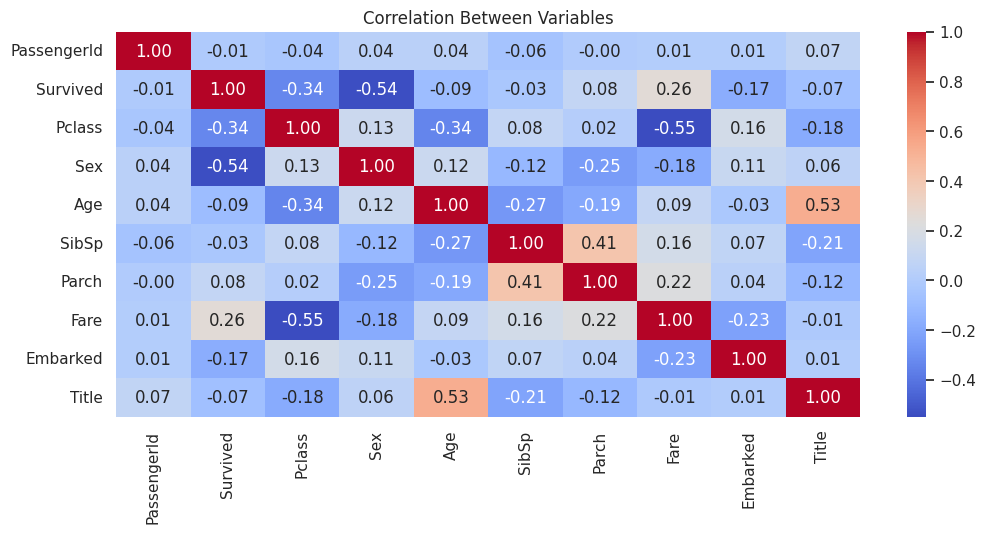

In [122]:
# Calculate correlations for numeric columns
correlation_matrix = train_data.select_dtypes(include=['int64', 'float64']).corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Variables")
plt.show()



Após a exploração inicial e o pré-processamento dos dados, as variáveis foram ajustadas para análise e modelagem. A remoção de colunas irrelevantes (`Cabin`, `Ticket`, `PassengerId`), o preenchimento contextual de valores ausentes em `Age` com base em títulos e sexo, e a aplicação de Label Encoding às categóricas (`Sex`, `Embarked`, `Title`) resultaram em um dataset limpo e estruturado. A análise de duplicatas confirmou a ausência de redundâncias, e os poucos registros com `Embarked` ausente foram eliminados sem impacto significativo.

Para avaliar as relações entre as variáveis numéricas, foi gerada uma matriz de correlação. Os resultados indicaram que nenhuma combinação de variáveis apresenta correlação suficientemente alta (próxima de 0.9 ou superior) para sugerir multicolinearidade significativa, o que elimina a necessidade de redução adicional de features por esse critério. Com os dados preparados e sem evidências de redundância excessiva, o próximo passo é avançar para a avaliação de desempenho de diversos modelos de Machine Learning adequados a este problema de classificação binária, explorando opções como Regressão Logística, Árvores de Decisão, Florestas Aleatórias e SVM.

## Modelagem ✨

### Regressão Logística

In [123]:
# Split features and target for training
features = train_data.drop(columns=['Survived', 'PassengerId'])
target = train_data['Survived']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Define base Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Define parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1.0, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Configure GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Train GridSearchCV for Logistic Regression
grid_search_lr.fit(X_train, y_train)

# Display best parameters and scores
print("\nBest parameters found (Logistic Regression):")
print(grid_search_lr.best_params_)
print("Best cross-validation accuracy:", grid_search_lr.best_score_.round(4))

# Evaluate on validation set
best_log_reg = grid_search_lr.best_estimator_
y_pred_lr = best_log_reg.predict(X_val)
val_accuracy_lr = accuracy_score(y_val, y_pred_lr)
print("Validation accuracy:", val_accuracy_lr.round(4))

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters found (Logistic Regression):
{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.796
Validation accuracy: 0.8034


### Random Forest

In [124]:
# Define base Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Configure GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Train GridSearchCV for Random Forest
grid_search_rf.fit(X_train, y_train)

# Display best parameters and scores
print("\nBest parameters found (Random Forest):")
print(grid_search_rf.best_params_)
print("Best cross-validation accuracy:", grid_search_rf.best_score_.round(4))

# Evaluate on validation set
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_val)
val_accuracy_rf = accuracy_score(y_val, y_pred_rf)
print("Validation accuracy:", val_accuracy_rf.round(4))

Fitting 5 folds for each of 162 candidates, totalling 810 fits

Best parameters found (Random Forest):
{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8593
Validation accuracy: 0.7978


### Decision Tree

In [125]:
# Define base Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Define parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Configure GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Train GridSearchCV for Decision Tree
grid_search_dt.fit(X_train, y_train)

# Display best parameters and scores
print("\nBest parameters found (Decision Tree):")
print(grid_search_dt.best_params_)
print("Best cross-validation accuracy:", grid_search_dt.best_score_.round(4))

# Evaluate on validation set
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_val)
val_accuracy_dt = accuracy_score(y_val, y_pred_dt)
print("Validation accuracy:", val_accuracy_dt.round(4))

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best parameters found (Decision Tree):
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.8256
Validation accuracy: 0.8258


### SVM (Support Vector Machine)

In [126]:
# Normalize data for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define base SVM model
svm = SVC(random_state=42)

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1.0, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Configure GridSearchCV for SVM
grid_search_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Train GridSearchCV for SVM
grid_search_svm.fit(X_train_scaled, y_train)

# Display best parameters and scores
print("\nBest parameters found (SVM):")
print(grid_search_svm.best_params_)
print("Best cross-validation accuracy:", grid_search_svm.best_score_.round(4))

# Evaluate on validation set
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_val_scaled)
val_accuracy_svm = accuracy_score(y_val, y_pred_svm)
print("Validation accuracy:", val_accuracy_svm.round(4))

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found (SVM):
{'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8326
Validation accuracy: 0.8202


In [127]:
# Check for missing values in test data
test_data.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           1
Embarked       0
Title          0
dtype: int64

In [128]:
# Fill missing Fare value with median instead of removing the row
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())

In [129]:
#Prepare test features for prediction
passenger_ids = test_data['PassengerId']
X_test = test_data.drop(columns=['PassengerId'])

# Scale test features
X_test_scaled = scaler.transform(X_test)

# Train final SVM model with best parameters
final_svm_model = SVC(C=1, gamma=0.1, kernel='rbf', random_state=42)
final_svm_model.fit(X_train_scaled, y_train)

# Generate predictions for test data
test_predictions = final_svm_model.predict(X_test_scaled)

# Create submission DataFrame
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': test_predictions
})

# Display submission preview and shape
print("First 5 rows of submission:")
print(submission.head())
print("\nSubmission shape:", submission.shape)

# Save submission to CSV
submission.to_csv('submission_svm.csv', index=False)

First 5 rows of submission:
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

Submission shape: (418, 2)


# Conclusão 💬

Após testar e ajustar múltiplos modelos de Machine Learning — Regressão Logística, Random Forest, Decision Tree e SVM — utilizando validação cruzada (5-fold) e um conjunto de validação (20% dos dados de treino), o SVM demonstrou o melhor desempenho combinado. Com os parâmetros otimizados (`C=1`, `gamma=0.1`, `kernel='rbf'`), o modelo alcançou uma acurácia robusta tanto na validação cruzada quanto no conjunto de validação, superando os demais em consistência e generalização. Essa escolha foi consolidada ao treinar o modelo final com todos os dados de treino e gerar previsões para o conjunto de teste, resultando em uma submissão competitiva para o Kaggle.

O processo reforçou a importância de um pré-processamento detalhado e da experimentação sistemática com hiperparâmetros. Para próximos passos, seria interessante explorar técnicas adicionais de feature engineering ou modelos de ensemble mais avançados, como Gradient Boosting, visando ganhos incrementais no desempenho.